In [1]:
import pandas as pd
import numpy as np
import warnings

from sklearn.preprocessing import LabelEncoder
from sklearn import tree, linear_model, ensemble, svm
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt

In [2]:
warnings.filterwarnings("ignore")

### 1. 데이터 불러오기

In [3]:
featuresData = pd.read_csv("../dataset/kopo_decision_tree_all_new.csv")
print(type(featuresData), featuresData.shape)

<class 'pandas.core.frame.DataFrame'> (32415, 12)


In [4]:
len(featuresData.ITEM.unique())

491

In [5]:
groupKey = ["REGIONID", "ITEM"]

In [6]:
groupData = featuresData.groupby(groupKey)["QTY"]\
            .agg({"KNOB":"size"}).reset_index()
groupData.head()

,REGIONID,ITEM,KNOB
0,A01,ITEM001,3
1,A01,ITEM002,2
2,A01,ITEM003,1
3,A01,ITEM004,7
4,A01,ITEM005,8


In [7]:
mergedData = pd.merge(left=featuresData,
        right=groupData,
        on=groupKey,
        how="left")
mergedData.head(6)

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,HCLUS,PROMOTION,PRO_PERCENT,KNOB
0,A01,PG01,P01,ITEM001,201538,2015,38,1,N,4,N,0.0,3
1,A01,PG01,P01,ITEM001,201548,2015,48,1,Y,0,N,0.0,3
2,A01,PG01,P01,ITEM001,201549,2015,49,2,Y,0,N,0.0,3
3,A01,PG01,P01,ITEM002,201526,2015,26,1,Y,1,N,0.0,2
4,A01,PG01,P01,ITEM002,201532,2015,32,1,N,4,N,0.0,2
5,A01,PG01,P01,ITEM003,201553,2015,53,2,Y,1,N,0.0,1


### 2. 데이터 전처리 (MAX 실적 보유자료만 활용)

In [8]:
maxHistory = mergedData.KNOB.max()

In [9]:
cleansedData = mergedData[mergedData.KNOB >= maxHistory]

In [10]:
le_pro = LabelEncoder()

In [11]:
cleansedData["N_PRODUCTGROUP"] = le_pro.fit_transform(cleansedData.PRODUCTGROUP)
cleansedData["N_PRODUCT"] = le_pro.fit_transform(cleansedData.PRODUCT)

In [12]:
ynMap = {"Y":1, "N":0}
cleansedData["HOLI_YN"] = cleansedData.HOLIDAY.map(ynMap)
cleansedData["PROM_YN"] = cleansedData.PROMOTION.map(ynMap)
cleansedData.head(3)

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,HCLUS,PROMOTION,PRO_PERCENT,KNOB,N_PRODUCTGROUP,N_PRODUCT,HOLI_YN,PROM_YN
2352,A01,PG02,P03,ITEM043,201501,2015,1,87,Y,1,Y,0.19759,146,0,0,1,1
2353,A01,PG02,P03,ITEM043,201502,2015,2,60,N,4,Y,0.19759,146,0,0,0,1
2354,A01,PG02,P03,ITEM043,201503,2015,3,51,N,4,N,0.00000,146,0,0,0,0


In [13]:
len(cleansedData.ITEM.unique())

52

### 3. 전체 그룹 최적 MAE 검색

In [14]:
def predict_ml(onegroup):
    eachGroup = onegroup.reset_index(drop=True)

    ### 3-1. 특성선정

    corrdf = eachGroup.corr()
    corrStd = 0.6
    features = list(corrdf[(abs(corrdf.QTY) > corrStd) & (corrdf.QTY < 1)].index)
    label = ['QTY']
    
    if len(features) < 1:
        while (True) :
            corrStd -= 0.05
            features = list(corrdf[(abs(corrdf.QTY) > corrStd) & (corrdf.QTY < 1)].index)
            
            if len(features) > 0:
                break
    
    ## 만약 feature가 없는 경우 예측값 = 0 [과연 0?]
    ## 만약 feature가 있는 경우 예측 [3가지 방법으로 예측]
    ## 검증 [mae] 최소인 모델 > bestmodel 선정

    ### 3-2. 데이터 분리

    yearweekStd = 201701

    trainData_features = eachGroup[eachGroup.YEARWEEK < yearweekStd][features]
    trainData_label = eachGroup[eachGroup.YEARWEEK < yearweekStd][label]
    testData_features = eachGroup[eachGroup.YEARWEEK >= yearweekStd][features]
    testData_label = eachGroup[eachGroup.YEARWEEK >= yearweekStd][label]
    testData_all = eachGroup[eachGroup.YEARWEEK >= yearweekStd]

    ### 3-3. 모델 선언
    model_method_tr = tree.DecisionTreeRegressor(random_state=1)
    model_method_rf = ensemble.RandomForestRegressor(random_state=1)
    model_method_lr = linear_model.LinearRegression()
    model_method_svm = svm.SVR(gamma='scale', C=1.0, epsilon=0.2)

    ### 3-4. 훈련
    model_tr = model_method_tr.fit(trainData_features, trainData_label)
    model_rf = model_method_rf.fit(trainData_features, trainData_label)
    model_lr = model_method_lr.fit(trainData_features, trainData_label)
    model_svm = model_method_svm.fit(trainData_features, trainData_label)

    ### 3-5. 예측
    predict_tr = model_tr.predict(testData_features)
    predict_rf = model_rf.predict(testData_features)
    predict_lr = model_lr.predict(testData_features)
    predict_svm = model_svm.predict(testData_features)
    
    testData_all["TR_PREDICT"] = predict_tr
    testData_all["RF_PREDICT"] = predict_rf
    testData_all["LR_PREDICT"] = predict_lr
    testData_all["SVM_PREDICT"] = predict_svm

    mae_tr = mean_absolute_error(testData_all.QTY, testData_all.TR_PREDICT)
    mae_rf = mean_absolute_error(testData_all.QTY, testData_all.RF_PREDICT)
    mae_lr = mean_absolute_error(testData_all.QTY, testData_all.LR_PREDICT)
    mae_svm = mean_absolute_error(testData_all.QTY, testData_all.SVM_PREDICT)
    
    maeList = [mae_tr, mae_rf, mae_lr, mae_svm]
    maeDic = {mae_tr:"DecisionTreeRegressor", mae_rf:"RandomForestRegressor", mae_lr:"LinearRegression", mae_svm:"SVM"}
    model_name = np.array([maeDic[np.min(maeList)]]*len(testData_all))
    testData_all["MODEL"] = model_name
    corr_std = np.array([round(corrStd,2)]*len(testData_all))
    testData_all["COR_STD"] = corr_std
    maxMae = np.array([round(np.min(maeList),2)]*len(testData_all))
    testData_all["MIN_MAE"] = maxMae
    featureList = np.array([", ".join(features)]*len(testData_all))
    testData_all["FEATURES"] = featureList

#     print("ITEM:", testData_all.ITEM.unique(), ", MAE:", round(np.max(maeList),2), ", BestFit:", maeDic[np.max(maeList)], ", CORR:", round(corrStd,2), ", Feature", features)
    return testData_all

In [15]:
def final_summary(onedata):
    # groupedData2 = predictResult.groupby(groupKey)
    # onedata = groupedData2.get_group(list(groupedData2.groups)[0])

    targetColumns = ['ITEM', 'MIN_MAE', 'MODEL', 'COR_STD', 'FEATURES']

    outResult = onedata.head(1)[targetColumns]

    return outResult

In [16]:
predictResult = cleansedData.groupby(groupKey).apply(predict_ml, ).reset_index(drop=True)

In [17]:
predictResult.groupby(groupKey).apply(final_summary).reset_index(drop=True)

,ITEM,MIN_MAE,MODEL,COR_STD,FEATURES
0,ITEM043,134.33,DecisionTreeRegressor,0.60,PRO_PERCENT
1,ITEM044,4.04,RandomForestRegressor,0.60,"PRO_PERCENT, PROM_YN"
2,ITEM051,6.99,RandomForestRegressor,0.50,HCLUS
3,ITEM053,127.27,DecisionTreeRegressor,0.55,HCLUS
4,ITEM054,7.49,RandomForestRegressor,0.55,HCLUS
5,ITEM056,26.51,LinearRegression,0.55,PRO_PERCENT
6,ITEM084,26.01,SVM,0.50,HCLUS
7,ITEM085,9.53,SVM,0.45,HCLUS
8,ITEM141,14.32,RandomForestRegressor,0.60,PRO_PERCENT
9,ITEM142,263.79,RandomForestRegressor,0.55,"HCLUS, PRO_PERCENT"


In [18]:
itemIdx = 0 # 그래프 확인이 필요한 ITEM INDEX

In [19]:
predictGroup = predictResult.groupby(groupKey)

In [20]:
itemData = predictGroup.get_group(list(predictGroup.groups)[itemIdx])
yearVal = itemData["YEARWEEK"]
yearVal = yearVal - 201700
realVal = itemData["QTY"]
trVal = itemData["TR_PREDICT"]
svmVal = itemData["SVM_PREDICT"]
rfVal = itemData["RF_PREDICT"]
lrVal = itemData["LR_PREDICT"]

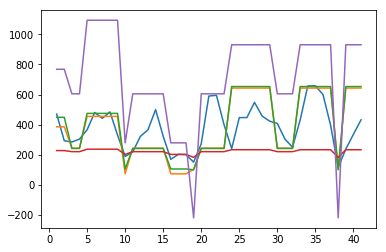

In [21]:
plt.plot(yearVal, realVal, yearVal, trVal, yearVal, rfVal, yearVal, svmVal, yearVal, lrVal)
plt.show()